# Raster data

## Some basic principles

> a raster graphic represents a two-dimensional picture as a rectangular matrix or grid of ~square pixels~
<div>
<img src="images/simple_raster.png" width="500"/>
</div>

source: [wikipedia](https://en.wikipedia.org/wiki/Raster_graphics#Image_storage)


In [1]:
import matplotlib.pyplot as plt
import numpy as np

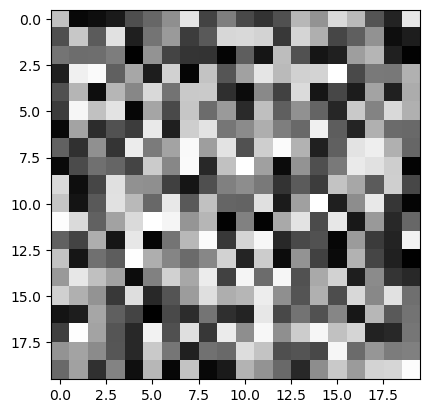

In [2]:
raster = np.random.rand(20, 20)
plt.imshow(raster, cmap="gray")

A simplistic representation of an image is just an array of shape `x, y, 3` where the last axis represents the red, green and blue chanels.

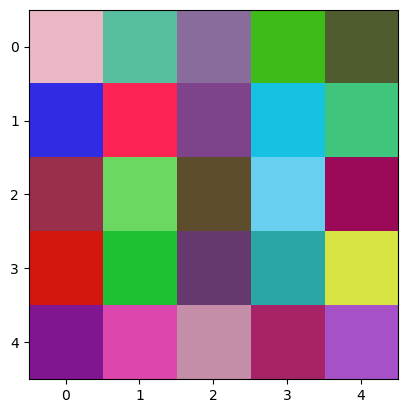

In [3]:
image = np.random.rand(5, 5, 3)
plt.imshow(image)

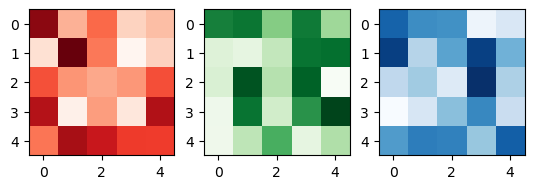

In [4]:
_, axs = plt.subplots(1, 3)
axs[0].imshow(image[:, :, 0], cmap="Reds")
axs[1].imshow(image[:, :, 1], cmap="Greens")
axs[2].imshow(image[:, :, 2], cmap="Blues")

In [5]:
plt.imsave("example.png", image)

## But...  maps?

Rasters can be _georeferenced_ to represent data on earth surface. 

In order to make it work we need to know
- where the raster is on earth
- the size of the pixels
- which reference system we are using: the Coordinate Reference System (CRS)

All this adds new metadata to our simple image format.

Here is where we will take advantage of libraries like [Rasterio](https://rasterio.readthedocs.io/en/latest/index.html).

Let's try to convert our image to fully privileged geospatial raster

In [6]:
import rasterio as rio
from rasterio.transform import Affine

# we are going to use a lat long projection so units must be in degrees
crs = "+proj=latlong"
# crs can also be defined using the espg code
crs = "epsg:4326"

# note it is negative! we are defining things from the upper left corner.
xres, yres = 0.005, -0.005

transform = Affine.translation(2.944591, 39.445561) * Affine.scale(xres, yres)

with rio.open(
    "raster.tiff",
    mode="w",
    height=image.shape[0],
    width=image.shape[1],
    count=3,  # number of band
    dtype=image.dtype,
    crs="+proj=latlong",
    transform=transform,
) as new_raster:

    # rasterio wants the axis in the order bands, cols, rows.
    new_raster.write(np.moveaxis(image, [0, 1, 2], [2, 1, 0]))

\- wowowo hold your horses, what is this affine, why multiply !?

\- It is just a way to define the upper left origin of our raster and the pixel size! it's super simple, you just needs to use a little bit of **linear algebra**

\* _leaves_


In [7]:
print(transform)

| 0.01, 0.00, 2.94|
| 0.00,-0.01, 39.45|
| 0.00, 0.00, 1.00|


\* Disclaimer: Sorry to all the people who knows linear algebra. I'm trying to do my best and be short

The `transform` variable is an `Affine`  object that represents an affine transformation like:


$$
\begin{vmatrix}
    x' \\
    y' \\
    1
\end{vmatrix}
= 
\begin{vmatrix}
    a & b & c \\
    d & e & f \\
    0 & 0 & 1
\end{vmatrix}
\ 
\begin{vmatrix}
    x \\
    y \\
    1
\end{vmatrix}
$$

Here with the matrix $\begin{vmatrix} a & b & c \\ d & e & f \\ 0 & 0 & 1\end{vmatrix}$ we transform the image coordinates $x, y$ to world coordinates $x', y'$

It is quite interesnting how this works but we don't have time. Look into [this](https://pygis.io/docs/d_affine.html) for a slightly deeper explaination or this [videos](https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab) if you want to get a full intuition on what is going on.

In our application most of the time we will only need `translate` (move the points) and to `scale`

so in the line 
```python
transform = Affine.translation(2.944591, 39.445561) * Affine.scale(xres, yres)
```
we are saying that our 0,0 pixel (in image coordinates, upper left corner) is at  39.445561°N 2.944591°E and the pixels measure 0.005° each side.

_**NOTE** that the units are in degrees because we are using a coordinate reference system that is in degrees!_

So the interesnting bits of our transform matrix are:

$$
\begin{vmatrix}
    x_{size} & \cdot & x_0 \\
    \cdot & y_{size} & y_0 \\
    \cdot & \cdot & \cdot
\end{vmatrix}
$$

this is why the affine object looks like:

```
| 0.005,     0,  2.94|
|     0,-0.005, 39.45|
|     0,     0,     1|
```

In [8]:
np.asarray(Affine.translation(10, 10) * Affine.scale(1, -1)).reshape(3,3) @ [1, 1, 1]

array([11.,  9.,  1.])

### Reprojecting

Now let's reproject a raster from one CRS to another